# Modelling poisson using PINN
__Author:  Manu Jayadharan__  
Written as part of FlowNet package, a TensorFlow based neural network package to solve fluid flow PDEs.

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 1D problem poisson problem

### Manufactured solution


We use $u = 3sin(4x)$ for $x\in [-1,1]$ 

### Importing packages

In [665]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Manufacturing data for trainig

In [666]:
np.random.seed(123)
X_tr_pde = np.random.uniform(-1,1,500).reshape(500,1)


#### Plotting histogram of randomly selected points to make sure they are uniformly distributed 

Text(0, 0.5, 'frequency ')

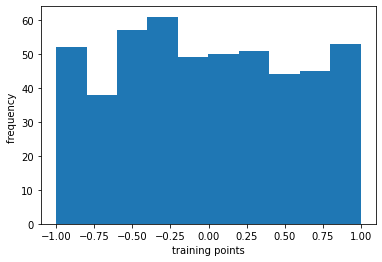

In [609]:
plt.hist(X_tr_pde)
plt.xlabel("training points")
plt.ylabel("frequency ")

In [610]:
Y_tr_pde = np.zeros((X_tr_pde.shape[0],1))

In [611]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(500, 2)

In [572]:
X_tr_Dr_bc_left = -1*np.ones(200).reshape(200,1)
X_tr_Dr_bc_right = 1*np.ones(200).reshape(200,1)
X_bc = np.concatenate([X_tr_Dr_bc_left,X_tr_Dr_bc_right],axis=0)

Y_tr_bc = 3*np.sin(4*X_bc)
Y_tr_bc = np.concatenate([Y_tr_bc,np.ones((Y_tr_bc.shape[0],1))],axis=1)


### Scaling the inputs(optional)

In [612]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_tr_pde = scaler.fit_transform(X_tr_pde)

In [613]:
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_tr_bc), axis=0)

In [614]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_tr = scaler.fit_transform(X_tr)
# X_tr.std()

In [615]:
(X_tr[0:3] +0.0056276)/4.520744138916567

array([[ 0.0881638 ],
       [-0.0933682 ],
       [-0.11959745]])

## Defining the NN model (custom Keras model)

- __Model specifications__: 7 layers: 1 input layer, 3 hidden layers with 20 neurons each, 1 dense intermediate layer, 1 gradient layer, 1 laplacian layer, 1 pde layer. 
- Output is a list of two elements: value of function and value of the pde operator.
- mean squared error is used for finding the cost function.
- Specialized, sgd( stochastic gradient descenet) type optimizer is used: either nadam or adam.
- tanh activation functions are used.


In [623]:
from tensorflow.keras import backend as K
class Poisson1d(tf.keras.Model):

    def __init__(self):
        super(Poisson1d, self).__init__()
#         self.batch_norm_ = keras.layers.BatchNormalization()
        self.flatten_input = keras.layers.Flatten()
        
        he_kernel_init = keras.initializers.he_uniform()
        
        self.dense_1 = keras.layers.Dense(20, activation="tanh",
                                          kernel_initializer=he_kernel_init,
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(20, activation="tanh",
                                          kernel_initializer=he_kernel_init,
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(20, activation="tanh",
                                          kernel_initializer=he_kernel_init,
                                         name="dense_3")
        self.dense_4 = keras.layers.Dense(1,
                                         name="dense_4")

    def findGrad(self,func,argm):
        return keras.layers.Lambda(lambda x: K.gradients(x[0],x[1])[0]) ([func,argm])
    
    def findPdeLayer(self, pde_lhs, input_arg):
        return keras.layers.Lambda(lambda z: z[0] + 48*tf.sin(4*z[1])) ([pde_lhs, input_arg])
    
    def call(self, inputs):
#         layer_0 = self.batch_norm_input(inputs)
        layer_0 = self.flatten_input(inputs)
#         layer_0_1 = self.batch_norm_input(layer_0)
        layer_1 = self.dense_1(layer_0)
#         layer_2_0 = self.batch_norm_input(layer_1)
        layer_2 = self.dense_2(layer_1)
#         layer_3_0 = self.batch_norm_(layer_2)
        layer_3 = self.dense_3(layer_2)
        layer_4 = self.dense_4(layer_3)
        
        grad_layer = self.findGrad(layer_4, inputs)
        laplace_layer = self.findGrad(grad_layer, inputs)
        pde_layer = self.findPdeLayer(laplace_layer, inputs)
        
        return layer_4, pde_layer



### Defining the loss functions

In [628]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
#     pde_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    pde_sq_error = (1/2)*tf.square(y_pred)
    return tf.where(at_boundary,0.,pde_sq_error)

### Instantiating  and compiling the poisson_model

In [633]:
poisson_NN = Poisson1d()

In [634]:
poisson_NN.compile(loss=[u_loss,pde_loss],optimizer="adam")

In [635]:
poisson_NN.fit(x=X_tr, y=Y_tr,epochs=100)

Epoch 1/100
29/29 [==============================] - 0s 8ms/step - loss: 259.7652 - output_1_loss: 1.6987 - output_2_loss: 258.0666
Epoch 2/100
29/29 [==============================] - 0s 8ms/step - loss: 199.6366 - output_1_loss: 3.7078 - output_2_loss: 195.9288
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 167.5798 - output_1_loss: 5.7012 - output_2_loss: 161.8786
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 147.2352 - output_1_loss: 6.9477 - output_2_loss: 140.2874
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 127.5192 - output_1_loss: 8.2436 - output_2_loss: 119.2756
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 107.6846 - output_1_loss: 9.3374 - output_2_loss: 98.3473
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 94.4738 - output_1_loss: 10.1162 - output_2_loss: 84.3576
Epoch 8/100
29/29 [==============================] - 0s 6ms/step - loss: 82.46

29/29 [==============================] - 0s 6ms/step - loss: 0.0613 - output_1_loss: 0.0069 - output_2_loss: 0.0544
Epoch 65/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0605 - output_1_loss: 0.0054 - output_2_loss: 0.0551
Epoch 66/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0541 - output_1_loss: 0.0045 - output_2_loss: 0.0496
Epoch 67/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0599 - output_1_loss: 0.0035 - output_2_loss: 0.0564
Epoch 68/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0621 - output_1_loss: 0.0029 - output_2_loss: 0.0592
Epoch 69/100
29/29 [==============================] - 0s 12ms/step - loss: 0.0662 - output_1_loss: 0.0025 - output_2_loss: 0.0637
Epoch 70/100
29/29 [==============================] - 0s 9ms/step - loss: 0.0576 - output_1_loss: 0.0017 - output_2_loss: 0.0559
Epoch 71/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0537 - output_1_loss: 0.0015 - o

## Testing the trained network

In [636]:
X_test_st = np.random.uniform(-1,1,100).reshape(100,1)

### Scaling the test set (only if the trainng data was scaled)

In [637]:
# #Scaling test set
# X_test_st_2 = scaler.transform(X_test_st)

#xtrain: mean, std: -0.005627660222786496 4.520744138916567

In [638]:
Y_test = poisson_NN.predict(X_test_st)

### Plotting the true and predicted solutions

Text(0.5, 1.0, 'True solution')

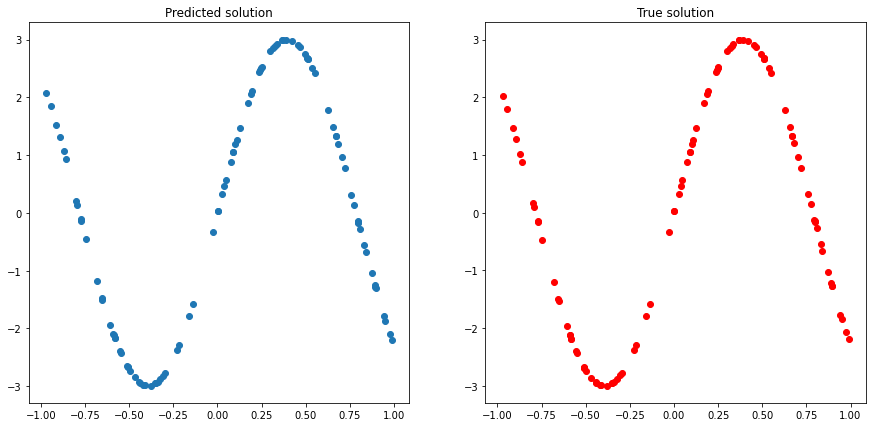

In [662]:
# fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(10,10))
#plotting predicted solution
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(X_test_st, Y_test[0][:,0])
plt.title("Predicted solution")

plt.subplot(1,2,2)
plt.scatter(X_test_st, 3*np.sin(4*X_test_st), c="r")
plt.title("True solution")


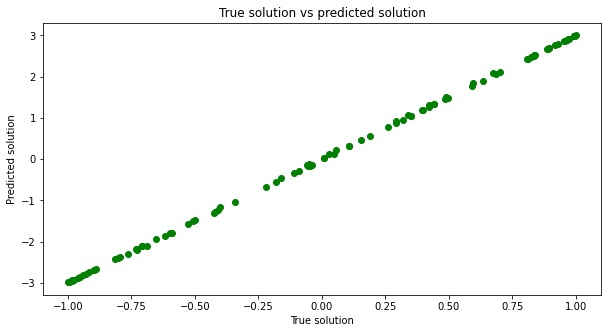

In [664]:
#True vs predicted solution
plt.figure(figsize=(10,5))
plt.scatter(np.sin(4*X_test_st), Y_test[0][:,0], c="g")
plt.title("True solution vs predicted solution")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

### Notes to be made

- For second order pde, some form of normalization is needed for convergence.
- If the the input data already comes normalized, there is no problem.
- If the data is not normalized, then we would want to some kind of normalization technique like batch normalization or normalization of incoming data.